In [31]:
HIGH_RISK = set(
    ("chest pain",
    "difficulty breathing",
    "unconscious",
    "seizure",
    "heavy bleeding",
    "suicidal thoughts",
    "stroke symptoms")
)

NEGATIONS = {"no", "not", "dont", "don't", "without"}
emergency_symptoms = {'high' , 'severe', 'sudden', 'unbearable', 'worsening', 'persistent'}
def check_risk(user_query: str) -> dict:
    user_query = user_query.lower()

    for symptom in HIGH_RISK:
        if symptom in user_query:
            
            words = user_query.split()
            symptom_words = symptom.split() #Check for simple negation

            for i in range(len(words) - len(symptom_words) + 1):
                if words[i:i+len(symptom_words)] == symptom_words:
                    
                    window = words[max(0, i-2):i] ## check previous 2 words for negation
                    if any(neg in window for neg in NEGATIONS):
                        continue

                    intensity_window = (
                        words[max(0, i-3):i] +
                        words[i+len(symptom_words): i+len(symptom_words)+3]
                    )
                    if any(emergency in window for emergency in intensity_window):
                        return {
                        "risk_level": "moderate - high",
                        "advice": "Seek immediate medical attention or call emergency services."
                        }
                    return {
                        "risk_level": "high",
                        "advice": "Seek immediate medical attention or call emergency services."
                    }

    return {
        "risk_level": "low",
        "advice": "Monitor your symptoms and consult a healthcare professional if they worsen."
    }


user_query = "I have no chest pain but high difficulty breathing."
result = check_risk(user_query)




In [32]:
result

{'risk_level': 'low',
 'advice': 'Monitor your symptoms and consult a healthcare professional if they worsen.'}

In [ ]:
import mysql.connector

def get_connection():
    return mysql.connector.connect(
        host="127.0.0.1",
        user="root",
        password="Msaa@1234",
        database="DoctorDB",
        port=3306
    )
    

In [46]:
import mysql.connector

try:
    conn = mysql.connector.connect(
        host="127.0.0.1",
        user="root",
        password="Msaa@1234",
        database="DoctorDB",
        port=3306
    )
    print("Database is running!")
    conn.close()
except:
    print("Database is NOT running.")


Database is running!


In [39]:
!pip install mysql-connector-python


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [47]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("groq_api_key")

model = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct")

prompt = ChatPromptTemplate(
    input_variables=["symptoms"],
    messages=[
        SystemMessage(content="You are a helpful assistant."),
        HumanMessage(content="{symptoms}")
    ]
)

graph = StateGraph()

graph.add_node("llm", model)





# while True:
#     print("\n--- AI Medical Agent ---")
#     user_input = input("You: ")
#     if user_input.lower() == "exit" or user_input.lower() == "quit":
#         break
    
#     response = chain.invoke({"symptoms": user_input})
#     print("Agent: ", response)
    



TypeError: StateGraph.__init__() missing 1 required positional argument: 'state_schema'

In [54]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph
from dotenv import load_dotenv
import os
import asyncio
import operator
from langchain_core.messages import AnyMessage , AIMessage , HumanMessage
from typing_extensions import Annotated , TypedDict
from mcp_use import MCPAgent, MCPClient

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("groq_api_key")

model = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct")

prompt = ChatPromptTemplate(
    input_variables=["symptoms"],
    messages=[
        SystemMessage(content="You are a helpful assistant."),
        HumanMessage(content="{symptoms}")
    ]
)
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage] , operator.add]

async def mcp_call(state: GraphState) -> GraphState:
    """Calls the MCP server with the current graph state and updates the graph state with the response"""
    
    client = "{config_mcp.json}"

    client = MCPClient.from_dict(client)

    mcp_agent = MCPAgent(llm_call , client = client)
    result = await mcp_agent.run(state)
    
    return result



def llm_call(state:GraphState) -> GraphState:
    """Calls the LLM with the current graph state and updates the graph state with the response"""
    response = model.invoke(state["messages"])
    state["messages"].append(response)
    return state

graph = StateGraph(GraphState)

graph.add_node("llm_call", llm_call)
graph.add_node("mcp_call" , mcp_call)


graph.set_entry_point("mcp_call")
graph.add_edge("mcp_call" , "llm_call")
graph.set_finish_point("llm_call")



# while True:
#     print("\n--- AI Medical Agent ---")
#     user_input = input("You: ")
#     if user_input.lower() == "exit" or user_input.lower() == "quit":
#         break
    
#     response = chain.invoke({"symptoms": user_input})
#     print("Agent: ", response)
    



In [55]:
app = graph.compile()

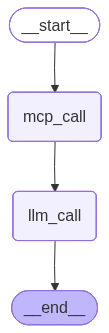

In [56]:
app

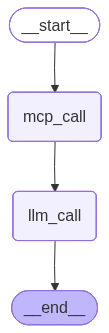

In [57]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

In [4]:
async def mcp_call(state: GraphState) -> GraphState:
    """Calls the MCP server with the current graph state and updates the graph state with the response"""
    
    with open("config_mcp.json", "r") as f:
        config = json.load(f)
  
    client = MCPClient.from_dict(config)

    mcp_agent = MCPAgent(model, client=client)
    
    query = state["messages"][-1].content
    
    response_content = await mcp_agent.run(query)
    
    
    return {"messages": [AIMessage(content=str(response_content))]}

In [5]:
res = mcp_call({"messages": [HumanMessage(content="high fever")]})

In [10]:
print(type(res))

<class 'coroutine'>


In [9]:
dir(res)

['__await__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'cr_await',
 'cr_code',
 'cr_frame',
 'cr_origin',
 'cr_running',
 'cr_suspended',
 'send',
 'throw']

In [14]:
symptom = "chest pain"

In [16]:
print(symptom.split())

['chest', 'pain']


In [17]:
"".join(symptom.split())

'chestpain'